In [31]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
from operators import *

In [32]:
h=np.pi*0.99
m=1.0
J=1.0
hz=0.1
hx=0.0
n_dis=100
#index=1
f=0.9

In [33]:
sz = np.array([[1,0],[0,-1]])
sx = np.array([[0,1],[1,0]])

In [34]:
kick = la.expm(-1j*h*sx/2)

In [35]:
def build_H(J,m,hz,hx,L):
    dim = 2**L
    H = np.zeros((dim, dim), dtype=float)
    g = np.random.choice([1,-1], size=L)
    #print(g)
    for site in range(L):
        H=H+(J-g[site]*m/2)*two_site_op(sz, sz, site, site+1, L)
        H=H+hx*one_site_op(sx, site, L)
        H=H+hz*one_site_op(sz, site, L)
    return H

In [36]:
sizes = [2,3,4,5,6,7,8]
#time_set = np.power(2, np.arange(40))
#time_set=np.arange(60000, step=19)
time_set = (np.power(1.2, np.arange(120))).astype(int)
Z=np.zeros((len(sizes), len(time_set)), dtype=complex)
varZ=np.zeros((len(sizes), len(time_set)), dtype=complex)
hist=[]


for countL, L in enumerate(sizes):
    n_dec=np.empty((L,n_dis))
    
    #flips = L-int(L*f)
    #index=np.sum(np.power(2, np.random.randint(L, size=flips)))
    #initial_state[index]=1
    #print("Initial state (local magnetization) ",\
    #      [expect_val(one_site_op(sz, i, L), initial_state) for i in range(L)])

    K = kick
    for _ in range(L-1):
        K = np.kron(K, kick)

    
    for counter in range(n_dis):
        start = time.time()
        
        initial_state=np.zeros(2**L)
        #flips = L-int(L*f)
        index=np.sum(np.power(2, np.arange(L))*np.random.binomial(1, 1-f, size=L))
        initial_state[index]=1
        #print(initial_state)

        H = build_H(J,m,hz,hx,L)
        U_F = np.dot(la.expm(-1j*H),K)
        eigval, eigvec = np.linalg.eig(U_F)
        spectrum = np.angle(eigval)

        final_state = evolve(time_set, initial_state, eigvec, eigval)
        for i in range(L):
            val=expect_val(one_site_op(sz, i, L), initial_state)*\
                     expect_val(one_site_op(sz, i, L),final_state)\
                     *(-1)**(time_set%2)
            Z[countL]+=val
            varZ[countL]+=val**2 
            n_dec[i, counter] = np.argmax(val<0.)
        elapsed = time.time()-start
    hist.append(n_dec)
        
        #print('size', L, '\tdisorder realization', counter,'\ttime elapsed', elapsed)
        
    Z[countL]=Z[countL]/(L*n_dis)
    varZ[countL]=(varZ[countL]/(L*n_dis)-Z[countL]**2)/(L*n_dis-1)

/home/federica/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


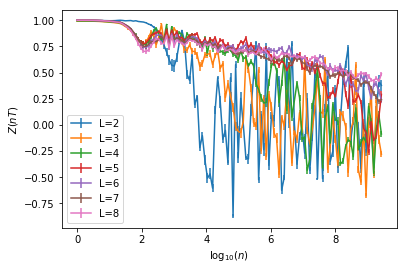

In [37]:
%matplotlib inline
for i, row in enumerate(Z):
    plt.errorbar(np.log10(time_set), row, yerr=np.sqrt(varZ[i]), label='L=%d' %sizes[i])
plt.ylabel(r'$Z(nT)$')
plt.xlabel(r'$\log_{10}(n)$')
plt.legend()
plt.show()

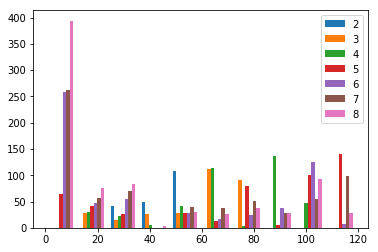

In [38]:
plt.hist(hist, label=sizes)
plt.legend()
plt.show()


/home/federica/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


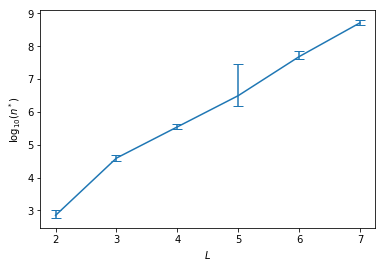

In [38]:
n_star = np.zeros(len(sizes), dtype=np.int32)
n_star_max = np.zeros(len(sizes), dtype=np.int32)
n_star_min = np.zeros(len(sizes), dtype=np.int32)
for i, row in enumerate(Z):
    n_star_max[i]=np.argmax(row+np.sqrt(varZ[i])<0.)
    n_star_min[i]=np.argmax(row-np.sqrt(varZ[i])<0.)
    n_star[i] = np.argmax(row<0.)
y = np.ma.masked_where(n_star_max <1, np.log10(time_set[n_star]))
y_max = np.ma.masked_where(n_star_max <1, np.log10(time_set[n_star_max+1]))
y_min = np.ma.masked_where(n_star_max <1, np.log10(time_set[n_star_min-1]))
#errorbars = np.log10(time_set[n_star_max])-np.log10(time_set[n_star_min])/2
#plt.plot(sizes, y)
#plt.fill_between(sizes, y_min, y_max, alpha=0.2)
plt.errorbar(sizes, y, yerr=[y-y_min, y_max-y],capsize=5)
plt.xlabel(r'$L$')
plt.ylabel(r'$\log_{10}(n^*)$')
plt.show()

In [30]:
np.random.binomial(1, 0.1, size=15)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])